In [1]:
from mp_api.client import MPRester
from mp_api.client.routes.materials.elasticity import ElasticityRester
import tqdm,os
import numpy as np


/Users/ts/opt/miniconda3/envs/matprj/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download all elasticity data from materials project

- beware that GPT autocomplete is biased by legacy API! The suggestions do not work!

In [3]:
mpr = ElasticityRester(os.environ.get("MP_API_KEY")) # free account to get your own key
elastic_data = mpr.search(fields=['elastic_tensor','shear_modulus','bulk_modulus','structure','nelements'])

Retrieving ElasticityDoc documents: 100%|██████████| 12392/12392 [00:24<00:00, 499.19it/s]


Filter all single element systems and extract 6x6 elastic constant tensor

In [32]:
elastic_tensors = []
lattice_constants = []
for m in tqdm.tqdm(elastic_data):
    # unaries
    if m.nelements>1: 
        continue
    # primitive cells...
    if len(m.structure.sites)>1:
        continue
    # sanity check
    if m.structure.lattice is None:
        continue

    if m.elastic_tensor is not None:
        C11 = m.elastic_tensor.ieee_format[0][0]
        if C11<1e5 and C11>0.0: # sanity check
            elastic_tensors += [m.elastic_tensor.ieee_format]
            
            # check this is accurate... probably not!
            lattice_constants += [m.structure.lattice.abc[0]] 
            
elastic_tensors = np.array(elastic_tensors)
lattice_constants = np.array(lattice_constants)
print(f"""
Elastic Tensors Shape: {elastic_tensors.shape}
Lattice Constants Shape: {lattice_constants.shape}
""")    

100%|██████████| 12392/12392 [00:00<00:00, 2448686.29it/s]


Elastic Tensors Shape: (110, 6, 6)
Lattice Constants Shape: (110,)



Select cubic-like materials

In [33]:
# select cubic-like materials
select = np.isclose(elastic_tensors[:,0,0],elastic_tensors[:,1,1],rtol=1e-2)
select *= np.isclose(elastic_tensors[:,0,0],elastic_tensors[:,2,2],rtol=1e-2)
select *= np.isclose(elastic_tensors[:,3,3],elastic_tensors[:,4,4],rtol=1e-2)
select *= np.isclose(elastic_tensors[:,3,3],elastic_tensors[:,5,5],rtol=1e-2)
select *= np.isclose(elastic_tensors[:,3,4],0.0,rtol=1e-2)
select *= np.isclose(elastic_tensors[:,3,5],0.0,rtol=1e-2)
select *= np.isclose(elastic_tensors[:,4,5],0.0,rtol=1e-2)
select *= elastic_tensors[:,4,4]>0.0 

Plot C11 vs C44 or C12 and with correlations - C11 vs C44 looks useful

C44 vs lattice constant with correlations - looks odd...

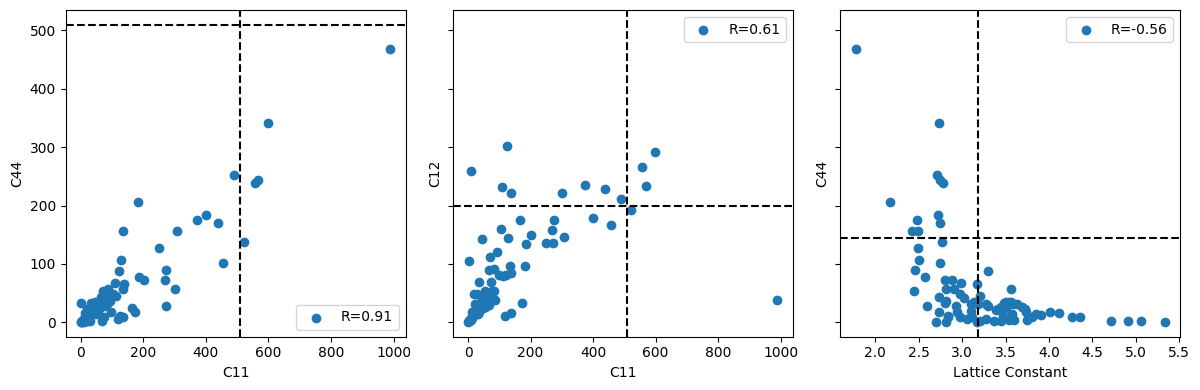

In [38]:
import matplotlib.pyplot as plt

C44_W = 144.
C11_W = 509.
C12_W = 200.


fig,axs = plt.subplots(1,3,figsize=(12,4),sharey=True)

x=elastic_tensors[select,0,0]
y=elastic_tensors[select,3,3]
R = np.corrcoef(x,y)
axs[0].scatter(x,y,label=f"R={R[0,1]:.2f}")

x=elastic_tensors[select,0,0]
y=elastic_tensors[select,0,1]
R = np.corrcoef(x,y)
axs[1].scatter(x,y,label=f"R={R[0,1]:.2f}")

x=lattice_constants[select]
y=elastic_tensors[select,3,3]
R = np.corrcoef(x,y)
axs[2].scatter(x,y,label=f"R={R[0,1]:.2f}")


axs[0].set_xlabel("C11")
axs[0].axvline(C11_W,color='k',ls='--')

axs[1].set_xlabel("C11")
axs[1].axvline(C11_W,color='k',ls='--')

axs[2].set_xlabel("Lattice Constant")
axs[2].axvline(3.18,color='k',ls='--')


axs[0].set_ylabel("C44")
axs[0].axhline(C11_W,color='k',ls='--')

axs[1].set_ylabel("C12")
axs[1].axhline(C12_W,color='k',ls='--')

axs[2].set_ylabel("C44")
axs[2].axhline(C44_W,color='k',ls='--')


axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.tight_layout()
